<a href="https://colab.research.google.com/github/Harukasawa/Harukasawa/blob/main/TUBES_VISKOM_Fachrul_Febriana_Alfi_Syahrin_Pratama_Abdul_Halim_Ichwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sign language recognition using CNN



Dalam Latihan ini kita akan melatih CNN untuk mengklasifikasikan gambar bahasa isyarat. Pada isi dari colab ini memiliki 4 bagian utama:
1. Memuat Data.
2. Mempersiapkan data untuk model (gambar dan label).
3. Membuat dan melatih model.
4. Mempresentasikan hasilnya.

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fachrulfebrianaa","key":"76626eeee8de6f584a3d9ebdb6e0376b"}'}

In [ ]:
!ls

kaggle.json  sample_data


In [ ]:
import os

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
!kaggle datasets download -d orihers/sign-language-images

 90% 29.0M/32.2M [00:00<00:00, 129MB/s] 
100% 32.2M/32.2M [00:00<00:00, 124MB/s]


In [ ]:
!unzip *.zip

Archive:  sign-language-images.zip
  inflating: Dataset/user_10/A0.jpg  
  inflating: Dataset/user_10/A1.jpg  
  inflating: Dataset/user_10/A2.jpg  
  inflating: Dataset/user_10/A3.jpg  
  inflating: Dataset/user_10/A4.jpg  
  inflating: Dataset/user_10/A5.jpg  
  inflating: Dataset/user_10/A6.jpg  
  inflating: Dataset/user_10/A7.jpg  
  inflating: Dataset/user_10/A8.jpg  
  inflating: Dataset/user_10/A9.jpg  
  inflating: Dataset/user_10/B0.jpg  
  inflating: Dataset/user_10/B1.jpg  
  inflating: Dataset/user_10/B2.jpg  
  inflating: Dataset/user_10/B3.jpg  
  inflating: Dataset/user_10/B4.jpg  
  inflating: Dataset/user_10/B5.jpg  
  inflating: Dataset/user_10/B6.jpg  
  inflating: Dataset/user_10/B7.jpg  
  inflating: Dataset/user_10/B8.jpg  
  inflating: Dataset/user_10/B9.jpg  
  inflating: Dataset/user_10/C0.jpg  
  inflating: Dataset/user_10/C1.jpg  
  inflating: Dataset/user_10/C2.jpg  
  inflating: Dataset/user_10/C3.jpg  
  inflating: Dataset/user_10/C4.jpg  
  inflating: Da

In [ ]:
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import keras
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization

Langkah pertama adalah memuat data dari folder Dataset, kami memuat semua gambar. Kami juga memuat data dari file csv yang akan membantu kami memotong gambar.

In [ ]:
def getFileName(path):
    return (path.split("../content/Dataset/")[1])

In [ ]:
# Variabel untuk menyimpan data gambar dan label
images = {}
metaData = []
folders = next(os.walk('../content/Dataset'))[1]

# Loop untuk membaca data dari setiap folder user
for folder in folders:
    csvFile = pd.read_csv("../content/Dataset/%s/%s_loc.csv" %(folder,folder))
    metaData.append(np.array(csvFile))
    for img in glob.glob("../content/Dataset/%s/*.jpg" %folder):
        n= mpimg.imread(img)
        picName = getFileName(img)
        images.update({picName : n})

Setelah memuat data kami memotong gambar sehingga kami hanya akan memiliki bagian "menarik" dari gambar, dan mengubah ukuran semua gambar ke ukuran yang sama (keras requirment).

In [ ]:
# Fungsi untuk pra-pemrosesan gambar dengan memotong dan mengubah ukuran
def preprocess(image,box):
    return cv2.resize(image[box[0]:box[1],box[2]:box[3]], (90,90))

In [ ]:
imagesAfterCrop = {}
for userImages in metaData:
    for img in userImages:
        imagesAfterCrop.update({img[0] : preprocess(images[img[0]],[img[2], img[4], img[1], img[3]])})

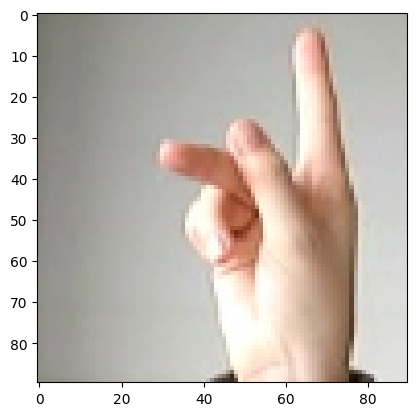

(90, 90, 3)

In [ ]:
img=imagesAfterCrop["user_3/K1.jpg"]
imgplot = plt.imshow(img)
plt.show()
imagesAfterCrop["user_3/K1.jpg"].shape

Di sini kita membuat array label, menggunakan nama gambar. Label adalah salah satu hot encoding, kami akan memastikan semuanya baik-baik saja dengan mencetak bentuk array label

In [ ]:
def createLabelsArray(images):
    # Counter untuk melacak jumlah gambar yang telah diproses
    counter = 0

    # Inisialisasi array labels dengan bentuk (jumlah gambar, 26) untuk merepresentasikan 26 kelas (A-Z)
    labels = np.zeros((len(images), 26))

    # Loop melalui setiap gambar untuk mengisi array labels
    for img in images:
        # Menggunakan nilai ASCII untuk menghitung indeks kelas dan mengatur nilai 1 pada posisi tersebut
        labels[counter][(ord(img.split('/')[1][0]) - ord('A'))] = 1
        counter = counter + 1  # Peningkatan counter untuk gambar berikutnya

    return labels

# Membuat array labels untuk gambar yang telah diproses
y = createLabelsArray(imagesAfterCrop)
print(y.shape)  # Menampilkan bentuk array labels

(1680, 26)


Membagi data untuk dilatih dan diuji, dan skala ulang semua nilai x(pixel) menjadi antara 0 sampai 1 (keras requirment)

In [ ]:
# Memisahkan data menjadi data latih dan data uji menggunakan train_test_split
x_train, x_test, y_train, y_test = train_test_split(list(imagesAfterCrop.values()), y, test_size=0.2, random_state=0)

# Mengonversi data latih dan data uji menjadi array numpy
x_train = np.array(x_train)
x_test = np.array(x_test)

# Normalisasi data dengan membagi nilai pixel dengan 255
x_train = x_train / 255
x_test = x_test / 255


## Membuat dan melatih model

In [ ]:
# Jumlah kelas atau label pada dataset
num_classes = 26

# Membangun arsitektur model menggunakan Sequential API dari Keras
model = keras.models.Sequential()

# Layer konvolusi pertama dengan 32 filter ukuran (3, 3) dan input shape (90, 90, 3)
model.add(keras.layers.Conv2D(32, (3, 3), input_shape=(90, 90, 3)))
model.add(keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Layer konvolusi kedua dengan 32 filter ukuran (3, 3)
model.add(keras.layers.Conv2D(32, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Layer konvolusi ketiga dengan 32 filter ukuran (3, 3)
model.add(keras.layers.Conv2D(32, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Meratakan output menjadi vektor
model.add(keras.layers.Flatten())

# Menambahkan layer Dense dengan 1024 neuron
model.add(keras.layers.Dense(1024))
model.add(keras.layers.Activation('relu'))
model.add(BatchNormalization())

# Menambahkan layer output Dense sesuai dengan jumlah kelas
model.add(keras.layers.Dense(num_classes))
model.add(keras.layers.Activation('softmax'))



In [ ]:
# Melatih model menggunakan optimasi RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

# Melatih model dengan data latih dan memonitor performa pada data uji
history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=50,
    validation_data=(x_test, y_test)
).history

Epoch 1/50
84/84 [==============================] - 30s 312ms/step - loss: 1.6222 - accuracy: 0.5499 - val_loss: 3.5367 - val_accuracy: 0.0417
Epoch 2/50
84/84 [==============================] - 22s 259ms/step - loss: 0.3546 - accuracy: 0.9100 - val_loss: 4.2518 - val_accuracy: 0.0417
Epoch 3/50
84/84 [==============================] - 20s 238ms/step - loss: 0.1272 - accuracy: 0.9829 - val_loss: 4.1867 - val_accuracy: 0.0952
Epoch 4/50
84/84 [==============================] - 20s 244ms/step - loss: 0.0425 - accuracy: 0.9970 - val_loss: 2.9641 - val_accuracy: 0.1845
Epoch 5/50
84/84 [==============================] - 21s 244ms/step - loss: 0.0255 - accuracy: 0.9985 - val_loss: 1.6208 - val_accuracy: 0.5446
Epoch 6/50
84/84 [==============================] - 20s 243ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.6951 - val_accuracy: 0.7857
Epoch 7/50
84/84 [==============================] - 21s 255ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.4351 - val_accuracy: 0.8631

In [ ]:
# Score model training
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

11/11 [==============================] - 1s 85ms/step - loss: 0.2546 - accuracy: 0.9256
Test loss: 0.25456541776657104
Test accuracy: 0.925595223903656


Kita mendapatkan akurasi 92% pada set pengujian.

In [ ]:
def decodeReal(yHat):
    return chr(np.argmax(yHat) + 97).upper()

def decodePrediction(number):
    return chr(number + 97).upper()

1/1 [==============================] - 0s 189ms/step
Huruf yang Diprediksi untuk Contoh #1 adalah K
Huruf Sebenarnya untuk Contoh #1 adalah K
1/1 [==============================] - 0s 25ms/step
Huruf yang Diprediksi untuk Contoh #2 adalah M
Huruf Sebenarnya untuk Contoh #2 adalah M
1/1 [==============================] - 0s 28ms/step
Huruf yang Diprediksi untuk Contoh #3 adalah K
Huruf Sebenarnya untuk Contoh #3 adalah K
1/1 [==============================] - 0s 25ms/step
Huruf yang Diprediksi untuk Contoh #4 adalah D
Huruf Sebenarnya untuk Contoh #4 adalah D
1/1 [==============================] - 0s 25ms/step
Huruf yang Diprediksi untuk Contoh #5 adalah R
Huruf Sebenarnya untuk Contoh #5 adalah U
1/1 [==============================] - 0s 25ms/step
Huruf yang Diprediksi untuk Contoh #6 adalah V
Huruf Sebenarnya untuk Contoh #6 adalah V
1/1 [==============================] - 0s 27ms/step
Huruf yang Diprediksi untuk Contoh #7 adalah G
Huruf Sebenarnya untuk Contoh #7 adalah G
1/1 [=======

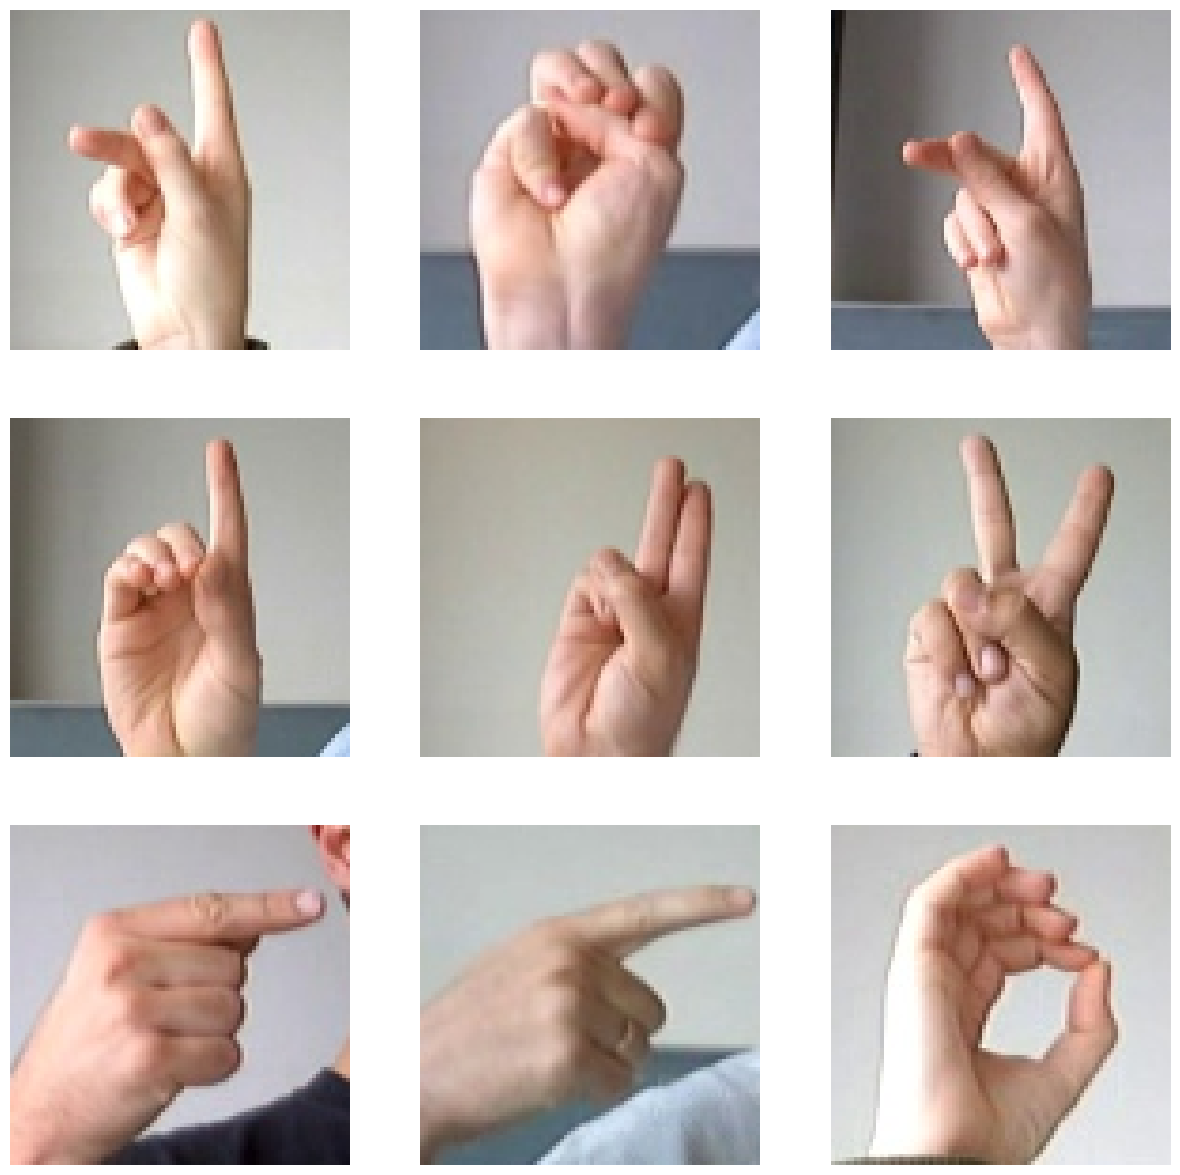

In [ ]:
# Membuat visualisasi prediksi untuk beberapa contoh data uji
fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 3

# Iterasi melalui beberapa contoh
for i in range(1, columns * rows + 1):
    img = x_test[0 + i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

    # Mencetak hasil prediksi dan karakter sebenarnya untuk setiap contoh
    prediction = decodePrediction(np.argmax(model.predict(np.array([x_test[i], ]))))
    print("Huruf yang Diprediksi untuk Contoh #" + str(i) + " adalah " + prediction)
    print("Huruf Sebenarnya untuk Contoh #" + str(i) + " adalah " + decodeReal(y_test[i]))

plt.show()

In [ ]:
allLettersTestArray = np.zeros(26)
allLettersTestMistakesArray = np.zeros(26)

counter = 0

for example in x_test:
    yhat = np.argmax(y_test[counter])
    allLettersTestArray[yhat] += 1
    if np.argmax(model.predict(np.array([x_test[counter],]))) != yhat:
        allLettersTestMistakesArray[yhat] += 1
    counter += 1

allLettersTestArray[allLettersTestArray == 0] = -1
mistakesPerLetter = allLettersTestMistakesArray / allLettersTestArray
lettersArray = np.array(list(map(chr, range(97, 123))))


df = pd.DataFrame({'huruf' : lettersArray, 'kesalahan' : mistakesPerLetter})

df['warna'] = 'g'
df.loc[df.kesalahan > 0.15, 'warna'] = 'r'

1/1 [==============================] - 0s 39ms/step


Text(0, 0.5, 'Frekuensi Kesalahan')

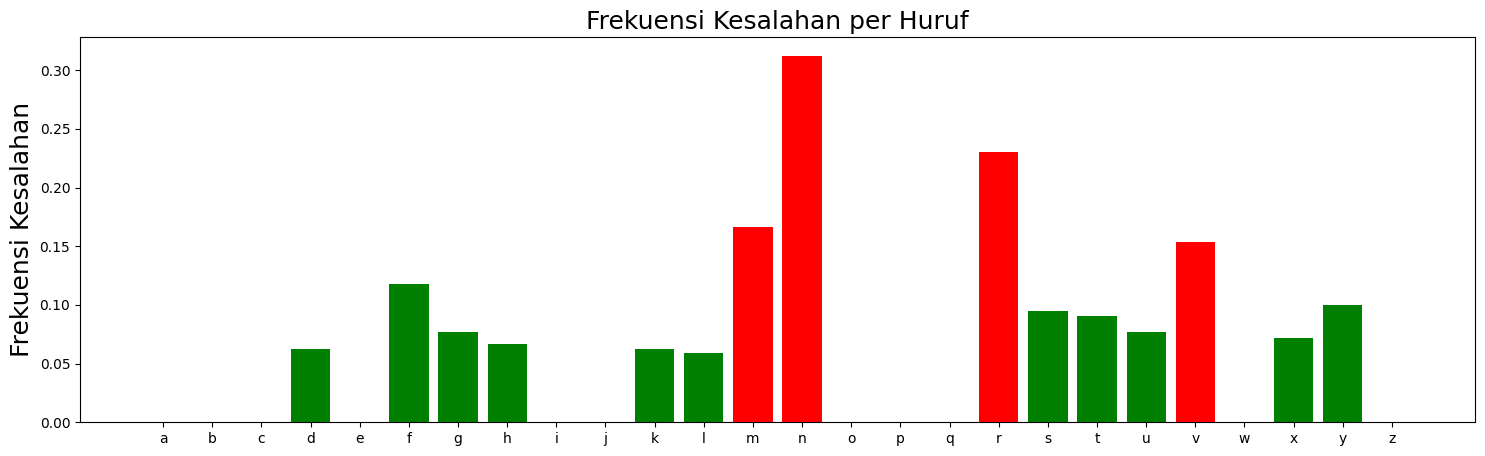

In [ ]:
# Membuat plot batang untuk frekuensi kesalahan berdasarkan huruf
f, ax = plt.subplots(figsize=(18,5))
plt.bar(df.huruf, df.kesalahan, color=df.warna)

# Menentukan judul dan label pada sumbu-y
ax.set_title('Frekuensi Kesalahan per Huruf', fontsize=18)
ax.set_ylabel('Frekuensi Kesalahan', fontsize=18)
